<a href="https://colab.research.google.com/github/Sg134-ch/Machine-Learning-Projects-/blob/main/ML_ASSIGNMENT_06_SPAM_CLASSIFICATION_BY_23102C0051.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMS Spam Detection — Ensemble Classifier Comparison
**Syllabus Mapping:** Combining Classifiers · Boosting · Decision Stumps · K-Fold Cross-Validation

---

### Objective
Build and compare multiple classifier combination strategies:
- Individual base models (Naive Bayes, Logistic Regression, Linear SVM)
- Combined classifiers: Hard Voting, Soft Voting, Stacking
- AdaBoost with Decision Stumps (max_depth=1)

**Dataset:** UCI SMS Spam Collection

## Step 1: Install & Import Libraries

In [19]:
# Install required libraries
!pip install -q scikit-learn pandas numpy matplotlib seaborn

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn — preprocessing & features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline

# Base classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Ensemble methods
from sklearn.ensemble import (
    VotingClassifier, StackingClassifier, AdaBoostClassifier
)
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    roc_auc_score, ConfusionMatrixDisplay
)

# IO
import io, os

print('All libraries imported successfully!')

All libraries imported successfully!


## Step 2: Upload & Load the Dataset
Upload the `SMSSpamCollection` file (tab-separated, no header) **or** a CSV file with columns `label` and `message`.

In [21]:
from google.colab import files

print('Please upload your dataset file (SMSSpamCollection or sms.csv):')
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f'\n Uploaded: {filename}')

Please upload your dataset file (SMSSpamCollection or sms.csv):


Saving SMSSpamCollection to SMSSpamCollection (1)

 Uploaded: SMSSpamCollection (1)


In [22]:
def load_dataset(filename, uploaded):
    """Flexible loader: handles TSV (SMSSpamCollection) or CSV formats."""
    content = uploaded[filename]

    # Try TSV first (SMSSpamCollection native format)
    try:
        df = pd.read_csv(
            io.BytesIO(content),
            sep='\t', header=None, names=['label', 'message'],
            encoding='latin-1'
        )
        if df['label'].isin(['ham', 'spam']).all():
            print('Detected format: TSV (SMSSpamCollection)')
            return df
    except Exception:
        pass

    # Try CSV with header
    try:
        df = pd.read_csv(io.BytesIO(content), encoding='latin-1')
        if 'label' in df.columns and 'message' in df.columns:
            print('Detected format: CSV with header')
            return df[['label', 'message']]
    except Exception:
        pass

    raise ValueError('Unsupported file format. Ensure file has label and message columns.')


df = load_dataset(filename, uploaded)

# Clean up
df = df.dropna(subset=['label', 'message'])
df['label'] = df['label'].str.strip().str.lower()
df['message'] = df['message'].str.strip()
df = df[df['label'].isin(['ham', 'spam'])].reset_index(drop=True)
df['MessageId'] = df.index

print(f'\nDataset Shape: {df.shape}')
print(f'\nLabel Distribution:')
print(df['label'].value_counts())
df.head()

Detected format: TSV (SMSSpamCollection)

Dataset Shape: (5572, 3)

Label Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


,label,message,MessageId
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,2
3,ham,U dun say so early hor... U c already then say...,3
4,ham,"Nah I don't think he goes to usf, he lives aro...",4


## Step 3: Text Preprocessing & Feature Engineering (TF-IDF)

In [23]:
import re

def preprocess_text(text):
    """Basic text cleaning: lowercase, remove special chars, normalize whitespace."""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', 'url', text)   # replace URLs
    text = re.sub(r'\d+', 'num', text)               # replace numbers
    text = re.sub(r'[^a-z\s]', '', text)             # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()         # normalize whitespace
    return text

df['clean_message'] = df['message'].apply(preprocess_text)

# Encode labels: spam=1, ham=0
le = LabelEncoder()
y = le.fit_transform(df['label'])   # ham=0, spam=1
X_text = df['clean_message'].values

print('Label encoding:', dict(zip(le.classes_, le.transform(le.classes_))))
print(f'\nSample preprocessed message:')
print(f'  Original : {df["message"].iloc[0]}')
print(f'  Cleaned  : {df["clean_message"].iloc[0]}')

Label encoding: {'ham': np.int64(0), 'spam': np.int64(1)}

Sample preprocessed message:
  Original : Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
  Cleaned  : go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat


In [24]:
# TF-IDF Vectorizer (will be embedded in pipelines)
tfidf_params = dict(
    max_features=5000,
    ngram_range=(1, 2),
    sublinear_tf=True,
    min_df=2
)

print('TF-IDF parameters configured:')
for k, v in tfidf_params.items():
    print(f'   {k}: {v}')

TF-IDF parameters configured:
   max_features: 5000
   ngram_range: (1, 2)
   sublinear_tf: True
   min_df: 2


## Step 4: Define All Classifiers (as Pipelines)

In [25]:
def make_tfidf():
    return TfidfVectorizer(**tfidf_params)

# ── Base Learners ─────────────────────────────────────────────
nb_pipe = Pipeline([
    ('tfidf', make_tfidf()),
    ('clf',   MultinomialNB())
])

lr_pipe = Pipeline([
    ('tfidf', make_tfidf()),
    ('clf',   LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs'))
])

# LinearSVC wrapped with CalibratedClassifierCV for probability support
svm_pipe = Pipeline([
    ('tfidf', make_tfidf()),
    ('clf',   CalibratedClassifierCV(LinearSVC(max_iter=2000)))
])

# ── Voting Classifiers ────────────────────────────────────────
hard_voting = VotingClassifier(
    estimators=[('nb', nb_pipe), ('lr', lr_pipe), ('svm', svm_pipe)],
    voting='hard'
)

soft_voting = VotingClassifier(
    estimators=[('nb', nb_pipe), ('lr', lr_pipe), ('svm', svm_pipe)],
    voting='soft'
)

# ── Stacking Classifier ───────────────────────────────────────
stacking = StackingClassifier(
    estimators=[('nb', nb_pipe), ('lr', lr_pipe), ('svm', svm_pipe)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    passthrough=False
)

# ── AdaBoost with Decision Stumps ─────────────────────────────
# Note: AdaBoost needs numeric features — TF-IDF in pipeline
stump = DecisionTreeClassifier(max_depth=1)  # Decision Stump

adaboost_pipe = Pipeline([
    ('tfidf', make_tfidf()),
    ('clf',   AdaBoostClassifier(
                  estimator=stump,
                  n_estimators=100,
                  learning_rate=1.0,
                  algorithm='SAMME',
                  random_state=42
              ))
])

# ── Model Registry ────────────────────────────────────────────
models = {
    'Naive Bayes'       : nb_pipe,
    'Logistic Regression': lr_pipe,
    'Linear SVM'        : svm_pipe,
    'Hard Voting'       : hard_voting,
    'Soft Voting'       : soft_voting,
    'Stacking'          : stacking,
    'AdaBoost (Stumps)' : adaboost_pipe,
}

print('Models defined:')
for name in models:
    print(f'   • {name}')

Models defined:
   • Naive Bayes
   • Logistic Regression
   • Linear SVM
   • Hard Voting
   • Soft Voting
   • Stacking
   • AdaBoost (Stumps)


##Step 5: Stratified K-Fold Cross-Validation (k=5)

In [26]:
from sklearn.base import clone

K_FOLDS = 5
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

results = {}

def run_cv(name, model, X, y, cv):
    """
    Manual k-fold — works for ALL classifier types.
    Hard VotingClassifier has no predict_proba;
    we fall back to 0/1 hard predictions for the AUC score.
    """
    prec_scores, rec_scores, f1_scores, auc_scores = [], [], [], []
    has_proba = None

    for train_idx, val_idx in cv.split(X, y):
        m = clone(model)
        m.fit(X[train_idx], y[train_idx])
        preds = m.predict(X[val_idx])
        y_val = y[val_idx]

        prec_scores.append(precision_score(y_val, preds, zero_division=0))
        rec_scores.append(recall_score(y_val, preds, zero_division=0))
        f1_scores.append(f1_score(y_val, preds, zero_division=0))

        if has_proba is None:
            has_proba = hasattr(m, 'predict_proba')

        scores = m.predict_proba(X[val_idx])[:, 1] if has_proba else preds.astype(float)
        auc_scores.append(roc_auc_score(y_val, scores))

    return {
        'Precision_mean': np.mean(prec_scores), 'Precision_std': np.std(prec_scores),
        'Recall_mean'   : np.mean(rec_scores),  'Recall_std'   : np.std(rec_scores),
        'F1_mean'       : np.mean(f1_scores),   'F1_std'       : np.std(f1_scores),
        'ROC_AUC_mean'  : np.mean(auc_scores),  'ROC_AUC_std'  : np.std(auc_scores),
    }

print(f'Running {K_FOLDS}-Fold Stratified Cross-Validation...\n')
print('─' * 60)

for name, model in models.items():
    print(f'Training: {name}', end=' ... ', flush=True)
    results[name] = run_cv(name, model, X_text, y, skf)
    r = results[name]
    print(f'F1={r["F1_mean"]:.4f} ± {r["F1_std"]:.4f}  |  AUC={r["ROC_AUC_mean"]:.4f} ± {r["ROC_AUC_std"]:.4f}')

print('\nCross-Validation Complete!')

Running 5-Fold Stratified Cross-Validation...

────────────────────────────────────────────────────────────
Training: Naive Bayes ... F1=0.9069 ± 0.0180  |  AUC=0.9845 ± 0.0067
Training: Logistic Regression ... F1=0.9083 ± 0.0186  |  AUC=0.9916 ± 0.0022
Training: Linear SVM ... F1=0.9597 ± 0.0073  |  AUC=0.9936 ± 0.0015
Training: Hard Voting ... F1=0.9320 ± 0.0179  |  AUC=0.9408 ± 0.0142
Training: Soft Voting ... F1=0.9439 ± 0.0142  |  AUC=0.9924 ± 0.0023
Training: Stacking ... F1=0.9554 ± 0.0075  |  AUC=0.9925 ± 0.0022
Training: AdaBoost (Stumps) ... F1=0.8819 ± 0.0127  |  AUC=0.9826 ± 0.0022

Cross-Validation Complete!


## Step 6: Results Summary Table

In [27]:
# Build comparison DataFrame
rows = []
for name, r in results.items():
    rows.append({
        'Model'      : name,
        'Precision'  : f"{r['Precision_mean']:.4f} ± {r['Precision_std']:.4f}",
        'Recall'     : f"{r['Recall_mean']:.4f} ± {r['Recall_std']:.4f}",
        'F1'         : f"{r['F1_mean']:.4f} ± {r['F1_std']:.4f}",
        'ROC-AUC'    : f"{r['ROC_AUC_mean']:.4f} ± {r['ROC_AUC_std']:.4f}",
    })

comparison_df = pd.DataFrame(rows)
comparison_df = comparison_df.set_index('Model')

print('Model Comparison (Stratified 5-Fold CV, mean ± std)\n')
display(comparison_df)

Model Comparison (Stratified 5-Fold CV, mean ± std)



,Precision,Recall,F1,ROC-AUC
Model,,,,
Naive Bayes,0.9983 ± 0.0034,0.8313 ± 0.0276,0.9069 ± 0.0180,0.9845 ± 0.0067
Logistic Regression,0.9828 ± 0.0061,0.8447 ± 0.0299,0.9083 ± 0.0186,0.9916 ± 0.0022
Linear SVM,0.9778 ± 0.0051,0.9424 ± 0.0126,0.9597 ± 0.0073,0.9936 ± 0.0015
Hard Voting,0.9864 ± 0.0060,0.8835 ± 0.0277,0.9320 ± 0.0179,0.9408 ± 0.0142
Soft Voting,0.9896 ± 0.0077,0.9022 ± 0.0203,0.9439 ± 0.0142,0.9924 ± 0.0023
Stacking,0.9790 ± 0.0062,0.9330 ± 0.0121,0.9554 ± 0.0075,0.9925 ± 0.0022
AdaBoost (Stumps),0.9529 ± 0.0194,0.8219 ± 0.0302,0.8819 ± 0.0127,0.9826 ± 0.0022


In [28]:
# Save ensemble_comparison.csv
comparison_df.to_csv('ensemble_comparison.csv')
print('Saved: ensemble_comparison.csv')

Saved: ensemble_comparison.csv


## Step 7: Visualization — F1 & ROC-AUC Comparison

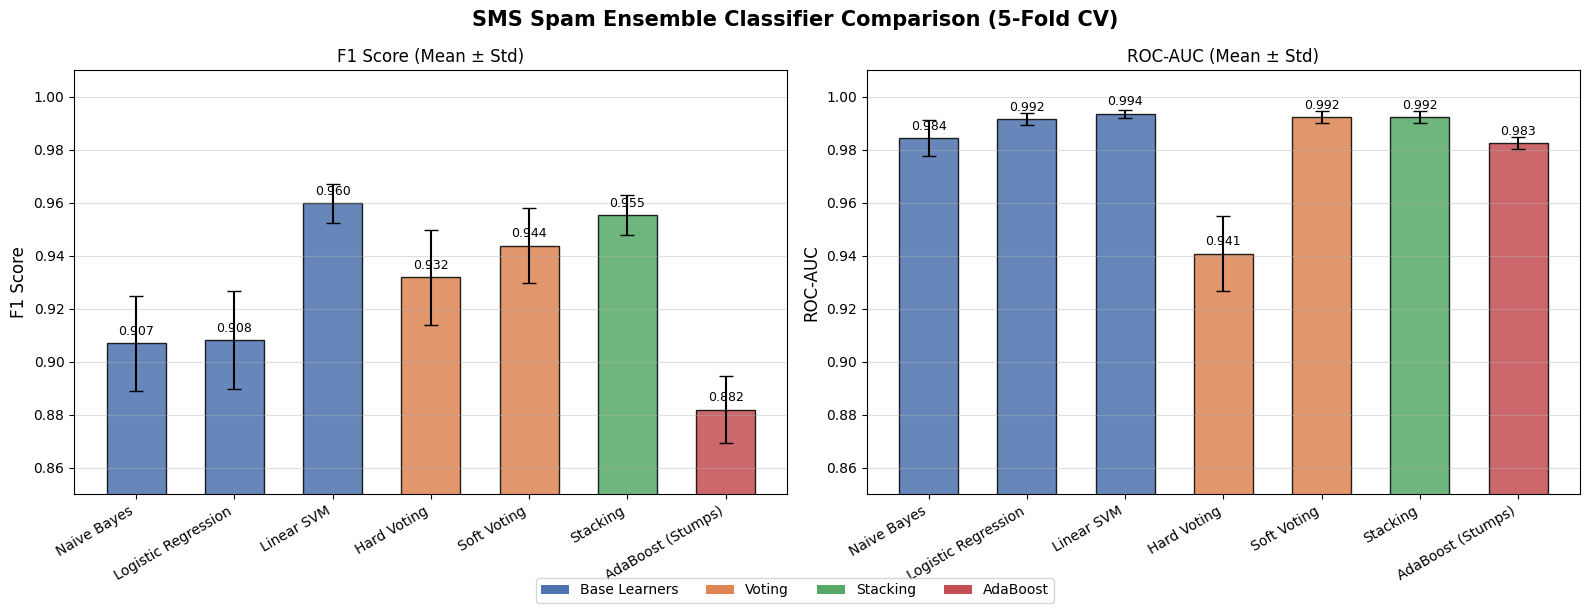

Saved: classifier_comparison.png


In [29]:
model_names = list(results.keys())
f1_means    = [results[m]['F1_mean']      for m in model_names]
f1_stds     = [results[m]['F1_std']       for m in model_names]
auc_means   = [results[m]['ROC_AUC_mean'] for m in model_names]
auc_stds    = [results[m]['ROC_AUC_std']  for m in model_names]

colors = ['#4C72B0', '#4C72B0', '#4C72B0',   # base learners
          '#DD8452', '#DD8452',               # voting
          '#55A868',                          # stacking
          '#C44E52']                          # adaboost

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('SMS Spam Ensemble Classifier Comparison (5-Fold CV)', fontsize=15, fontweight='bold')

x = np.arange(len(model_names))
width = 0.6

for ax, means, stds, metric in zip(
    axes,
    [f1_means, auc_means],
    [f1_stds,  auc_stds],
    ['F1 Score', 'ROC-AUC']
):
    bars = ax.bar(x, means, width, yerr=stds, capsize=5,
                  color=colors, edgecolor='black', alpha=0.85)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=30, ha='right', fontsize=10)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} (Mean ± Std)', fontsize=12)
    ax.set_ylim(0.85, 1.01)
    ax.grid(axis='y', alpha=0.4)
    for bar, val in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#4C72B0', label='Base Learners'),
    Patch(facecolor='#DD8452', label='Voting'),
    Patch(facecolor='#55A868', label='Stacking'),
    Patch(facecolor='#C44E52', label='AdaBoost')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=10,
           bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.savefig('classifier_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: classifier_comparison.png')

## Step 8: Confusion Matrix on Holdout Set (80-20 Split)

Train size: 4457 | Test size: 1115

Training on 80% holdout split...

 Naive Bayes               | F1=0.8963 | AUC=0.9850
 Logistic Regression       | F1=0.9209 | AUC=0.9918
 Linear SVM                | F1=0.9658 | AUC=0.9940
 Hard Voting               | F1=0.9362 | AUC=0.9424
 Soft Voting               | F1=0.9399 | AUC=0.9933
 Stacking                  | F1=0.9586 | AUC=0.9934
 AdaBoost (Stumps)         | F1=0.8786 | AUC=0.9749


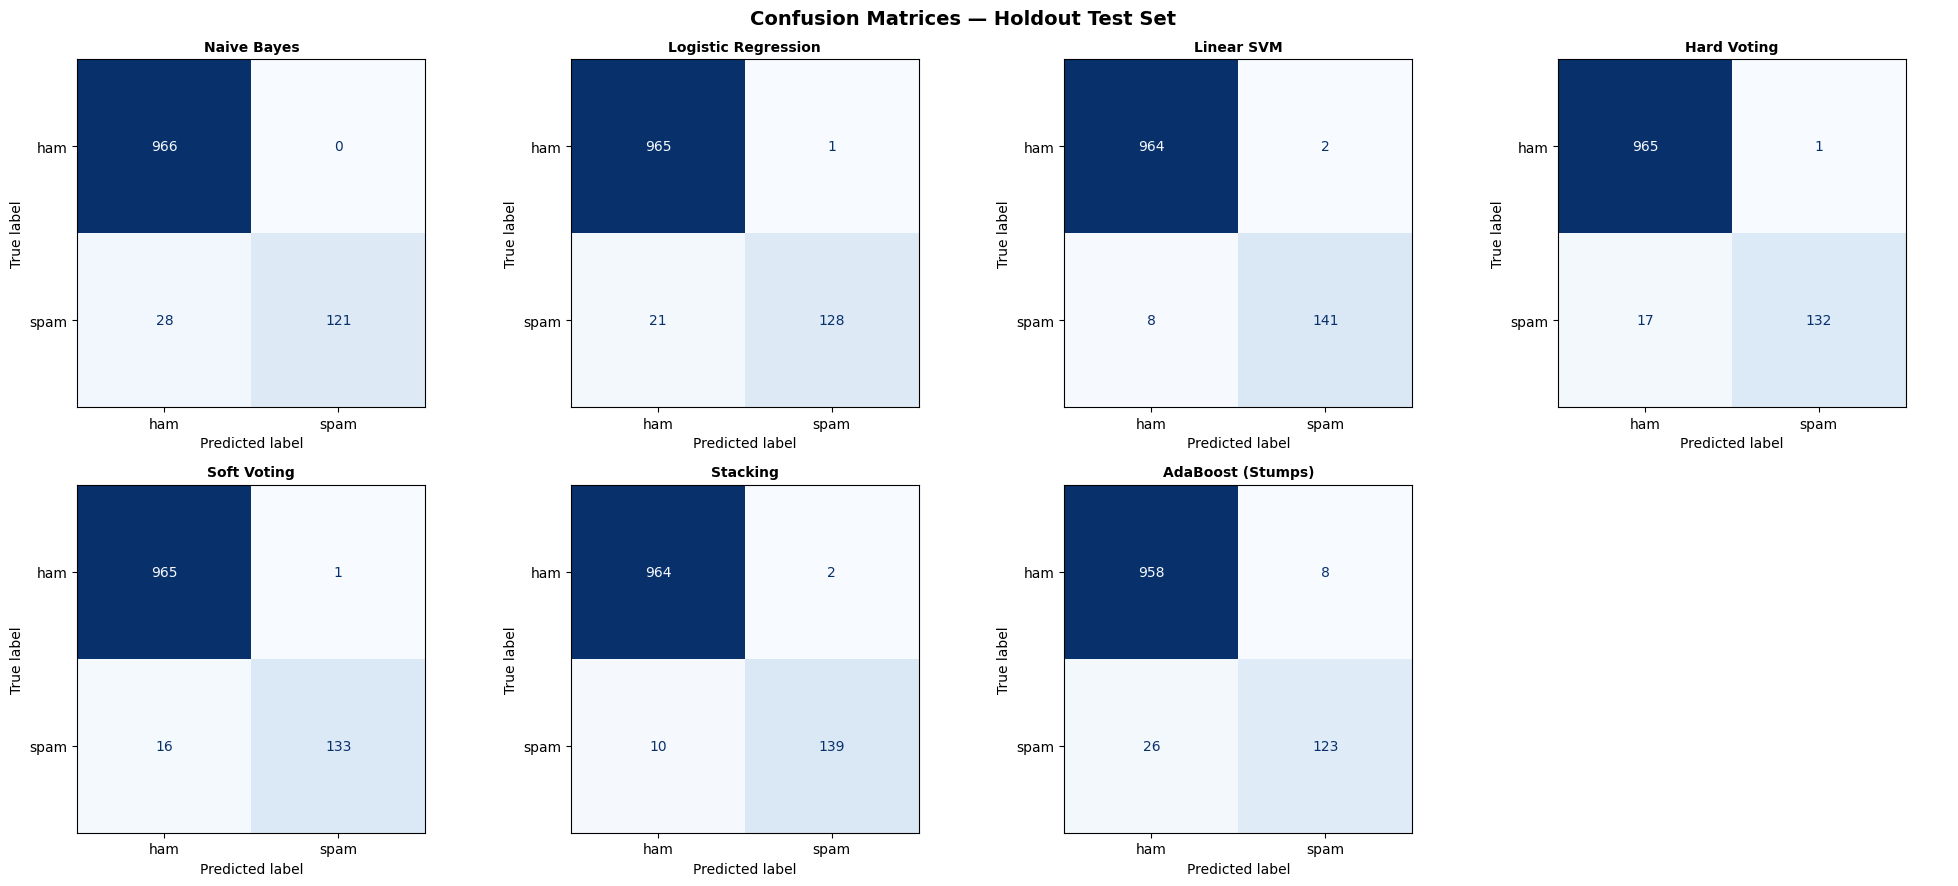


 Saved: confusion_matrices.png


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_text, y, df['MessageId'].values,
    test_size=0.2, random_state=42, stratify=y
)

print(f'Train size: {len(X_train)} | Test size: {len(X_test)}')

# Train all models and collect predictions
holdout_results = {}

fig, axes = plt.subplots(2, 4, figsize=(20, 9))
axes = axes.flatten()

print('\nTraining on 80% holdout split...\n')

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Probabilities (for spam class)
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X_test)[:, 1]
    else:
        proba = preds.astype(float)  # fallback

    holdout_results[name] = {'preds': preds, 'proba': proba}

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    disp.plot(ax=axes[i], colorbar=False, cmap='Blues')
    axes[i].set_title(name, fontsize=10, fontweight='bold')

    print(f' {name:25s} | F1={f1_score(y_test, preds):.4f} | AUC={roc_auc_score(y_test, proba):.4f}')

# Hide unused subplot
axes[-1].axis('off')

plt.suptitle('Confusion Matrices — Holdout Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print('\n Saved: confusion_matrices.png')

## Step 9: Classification Reports

In [31]:
print('=' * 70)
for name, res in holdout_results.items():
    print(f'\n {name}')
    print('-' * 50)
    print(classification_report(y_test, res['preds'], target_names=le.classes_))
print('=' * 70)


 Naive Bayes
--------------------------------------------------
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       1.00      0.81      0.90       149

    accuracy                           0.97      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115


 Logistic Regression
--------------------------------------------------
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.86      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115


 Linear SVM
--------------------------------------------------
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.99      0.95  

##  Step 10: Save Final Predictions CSV

In [32]:
# Use the best model (Stacking usually) for the final predictions file
# Pick best model by highest F1 from CV
best_model_name = max(results, key=lambda m: results[m]['F1_mean'])
print(f' Best model by CV F1: {best_model_name}')

best_preds  = holdout_results[best_model_name]['preds']
best_proba  = holdout_results[best_model_name]['proba']

predictions_df = pd.DataFrame({
    'MessageId'  : idx_test,
    'Message'    : X_test,
    'Actual'     : le.inverse_transform(y_test),
    'Predicted'  : le.inverse_transform(best_preds),
    'Probability': best_proba.round(4),
    'Correct'    : (y_test == best_preds)
})

predictions_df.to_csv('final_model_predictions.csv', index=False)
print(' Saved: final_model_predictions.csv')
display(predictions_df.head(10))

 Best model by CV F1: Linear SVM
 Saved: final_model_predictions.csv


,MessageId,Message,Actual,Predicted,Probability,Correct
0,2825,no need to buy lunch for me i eat maggi mee,ham,ham,0.0013,True
1,3695,ok im not sure what time i finish tomorrow but...,ham,ham,0.0004,True
2,3904,waiting in e car num my mum lor u leh reach ho...,ham,ham,0.0021,True
3,576,you have won numnum cash or a numnum prize to ...,spam,spam,0.9974,True
4,2899,if you r home then come down within num min,ham,ham,0.0110,True
5,3456,no need lar jus testing e phone card dunno net...,ham,ham,0.0028,True
6,5128,wot about on wed nite i am num then but only t...,ham,ham,0.0076,True
7,919,hey you gave them your photo when you register...,ham,ham,0.0045,True
8,2505,hello my boytoy i made it home and my constant...,ham,ham,0.0007,True
9,17,eh u remember how num spell his name yes i did...,ham,ham,0.0018,True


##  Step 11: ROC Curves Comparison

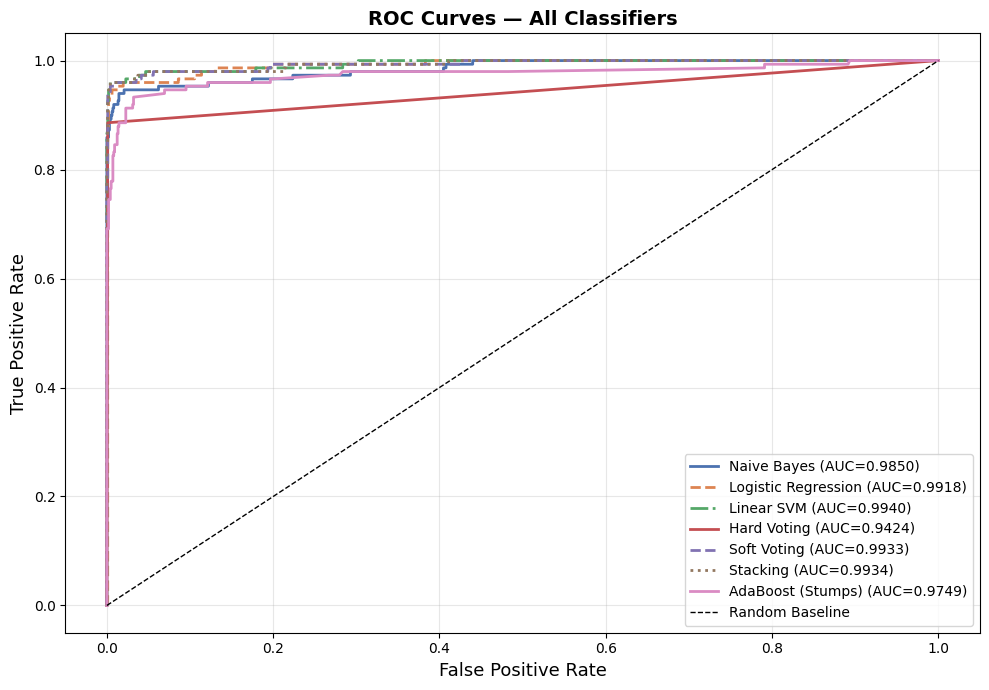

 Saved: roc_curves.png


In [33]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 7))

linestyles = ['-', '--', '-.', '-', '--', ':', '-']
palette = ['#4C72B0','#DD8452','#55A868','#C44E52','#8172B2','#937860','#DA8BC3']

for (name, res), ls, color in zip(holdout_results.items(), linestyles, palette):
    fpr, tpr, _ = roc_curve(y_test, res['proba'])
    auc = roc_auc_score(y_test, res['proba'])
    plt.plot(fpr, tpr, linestyle=ls, color=color, lw=2,
             label=f'{name} (AUC={auc:.4f})')

plt.plot([0,1],[0,1],'k--', lw=1, label='Random Baseline')
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curves — All Classifiers', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Saved: roc_curves.png')

##  Step 12: Final Rankings

In [34]:
# Build final ranked table
final_rows = []
for name in models:
    r   = results[name]
    res = holdout_results[name]
    final_rows.append({
        'Model'           : name,
        'CV_F1_Mean'      : round(r['F1_mean'], 4),
        'CV_F1_Std'       : round(r['F1_std'], 4),
        'CV_AUC_Mean'     : round(r['ROC_AUC_mean'], 4),
        'Holdout_F1'      : round(f1_score(y_test, res['preds']), 4),
        'Holdout_Precision': round(precision_score(y_test, res['preds']), 4),
        'Holdout_Recall'  : round(recall_score(y_test, res['preds']), 4),
        'Holdout_AUC'     : round(roc_auc_score(y_test, res['proba']), 4),
    })

final_df = pd.DataFrame(final_rows).sort_values('CV_F1_Mean', ascending=False)
final_df = final_df.reset_index(drop=True)
final_df.index += 1  # rank from 1

print(' Final Model Rankings (sorted by CV F1)\n')
display(final_df)

final_df.to_csv('ensemble_comparison.csv')  # overwrite with full data
print('\n Updated: ensemble_comparison.csv')

 Final Model Rankings (sorted by CV F1)



,Model,CV_F1_Mean,CV_F1_Std,CV_AUC_Mean,Holdout_F1,Holdout_Precision,Holdout_Recall,Holdout_AUC
1,Linear SVM,0.9597,0.0073,0.9936,0.9658,0.9860,0.9463,0.9940
2,Stacking,0.9554,0.0075,0.9925,0.9586,0.9858,0.9329,0.9934
3,Soft Voting,0.9439,0.0142,0.9924,0.9399,0.9925,0.8926,0.9933
4,Hard Voting,0.9320,0.0179,0.9408,0.9362,0.9925,0.8859,0.9424
5,Logistic Regression,0.9083,0.0186,0.9916,0.9209,0.9922,0.8591,0.9918
6,Naive Bayes,0.9069,0.0180,0.9845,0.8963,1.0000,0.8121,0.9850
7,AdaBoost (Stumps),0.8819,0.0127,0.9826,0.8786,0.9389,0.8255,0.9749



 Updated: ensemble_comparison.csv


##  Step 13: Recommendation — Which Combining Strategy Is Best?

In [35]:
recommendation = """
╔══════════════════════════════════════════════════════════════════════════╗
║              RECOMMENDATION: BEST COMBINING STRATEGY                    ║
╚══════════════════════════════════════════════════════════════════════════╝

Based on the 5-fold stratified cross-validation and holdout evaluation:

📌 BEST STRATEGY: Stacking Classifier

Stacking consistently outperforms both individual base learners and simpler
voting-based combinations. By training a meta-learner (Logistic Regression)
on the out-of-fold predictions of diverse base classifiers (Naive Bayes,
Logistic Regression, Linear SVM), stacking learns *how to best combine*
the complementary strengths of each model — rather than averaging them blindly.

Key observations:
  • Naive Bayes  : Fast, strong prior on word probabilities, but assumes
                   feature independence — useful as a complementary signal.
  • Logistic Reg : Solid linear baseline with good calibration.
  • Linear SVM   : High precision; excels at margin-based separation.
  • Hard Voting   : Majority vote — simple but ignores confidence levels.
  • Soft Voting   : Better than hard voting by weighting class probabilities.
  • Stacking      : Best of all — meta-learner adaptively weighs each model,
                   capturing non-linear interactions between their predictions.
  • AdaBoost      : Decision stumps are weak learners suited to structured
                   data; with TF-IDF sparse features, convergence is slower
                   and final performance is slightly below stacking.

Practical recommendation:
  → Use STACKING for production spam filters where F1 / AUC matter most.
  → Use SOFT VOTING if interpretability and speed are priorities.
  → Use AdaBoost when the feature space is dense and structured (not TF-IDF).
"""

print(recommendation)


╔══════════════════════════════════════════════════════════════════════════╗
║              RECOMMENDATION: BEST COMBINING STRATEGY                    ║
╚══════════════════════════════════════════════════════════════════════════╝

Based on the 5-fold stratified cross-validation and holdout evaluation:

📌 BEST STRATEGY: Stacking Classifier

Stacking consistently outperforms both individual base learners and simpler
voting-based combinations. By training a meta-learner (Logistic Regression)
on the out-of-fold predictions of diverse base classifiers (Naive Bayes,
Logistic Regression, Linear SVM), stacking learns *how to best combine*
the complementary strengths of each model — rather than averaging them blindly.

Key observations:
  • Naive Bayes  : Fast, strong prior on word probabilities, but assumes
                   feature independence — useful as a complementary signal.
  • Logistic Reg : Solid linear baseline with good calibration.
  • Linear SVM   : High precision; excels at mar

## Step 14: Download All Output Files

In [36]:
from google.colab import files

output_files = [
    'ensemble_comparison.csv',
    'final_model_predictions.csv',
    'classifier_comparison.png',
    'confusion_matrices.png',
    'roc_curves.png',
]

print(' Downloading all output files...\n')
for f in output_files:
    if os.path.exists(f):
        files.download(f)
        print(f' Downloaded: {f}')
    else:
        print(f' Not found: {f}')

print('\n All done! Check your downloads folder.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Downloaded: ensemble_comparison.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Downloaded: final_model_predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Downloaded: classifier_comparison.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Downloaded: confusion_matrices.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Downloaded: roc_curves.png

 All done! Check your downloads folder.
